In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  #disable tensorflow warnings

In [3]:

def read_from_source():
    df = pd.read_csv('https://toyokeizai.net/sp/visual/tko/covid19/csv/pcr_positive_daily.csv')
    df = df.rename(columns={'日付': 'Date', 'PCR 検査陽性者数(単日)': 'Infected'}) #renaming from Japanese to English
    df['Date'] = pd.to_datetime(df['Date'])
    return df



def pred_covid(model_name, df, model_idx): #GRU or LSTM
    #model = load_model('../'+model_name +'_infected_only_GRU_LSTM_Oct16.h5') #best
    model = load_model(model_name +'_infected_only_Oct17_'+str(model_idx)+'.h5')
    print(model_name,'loaded')

    #constant
    n_steps_in = 14
    n_steps_out = 4
    sc = MinMaxScaler(feature_range = (0, 1))
    
    x_input = df['Infected'][-n_steps_in:].values # last 14 day
    x_input = sc.fit_transform(x_input.reshape(len(x_input), 1))
    x_input = x_input.reshape((1, n_steps_in, 1))
    
    #y_pred = model.predict(x_input) # too much warnings
    y_pred = model(x_input)
    y_pred = sc.inverse_transform(y_pred) #revert scaling
    #print('Next 4 days prediction:', y_pred)
    
    start_date = str(df['Date'].iloc[-14])[:10]
    end_date = df['Date'].iloc[-15] + pd.Timedelta(18, unit='D')                  
    end_date = str(end_date)[:10]
    #print(start_date,'---', end_date)
    time_range = pd.date_range(start=start_date, end=end_date)
    
    pred_list = list(zip(time_range[-4:].strftime('%Y-%m-%d'), y_pred[0,:]))
    return pd.DataFrame (pred_list, columns = ['Date', 'Predict Infected'])

In [4]:
df = read_from_source()
df

,Date,Infected
0,2020-01-16,1.0
1,2020-01-17,0.0
2,2020-01-18,0.0
3,2020-01-19,0.0
4,2020-01-20,0.0
...,...,...
635,2021-10-12,609.0
636,2021-10-13,723.0
637,2021-10-14,612.0
638,2021-10-15,522.0


In [55]:
df[-14:]

,Date,Infected
626,2021-10-03,959.0
627,2021-10-04,576.0
628,2021-10-05,971.0
629,2021-10-06,1117.0
630,2021-10-07,969.0
631,2021-10-08,824.0
632,2021-10-09,770.0
633,2021-10-10,546.0
634,2021-10-11,359.0
635,2021-10-12,609.0


In [5]:
def get_prediction(model, df): #model = 'GRU' or 'LSTM'
    pred_arr = []
    for model_idx in [1,2,3]:
        #print(model,model_idx,pred_covid(model, df,model_idx))
        pred_arr.append(np.array(pred_covid(model, df,model_idx)['Predict Infected'].values))
    return np.array(pred_arr)

In [45]:
def get_PI(pred_arr):
    for idx in [0,1,2,3]:
        cov_std = pred_arr[:,idx].std()
        cov_interval = cov_std*1.96
        cov_mean = pred_arr[:,idx].mean()
        cov_lower = cov_mean - cov_interval
        cov_upper = cov_mean + cov_interval
        print(pred_arr[:,idx], cov_interval ,cov_lower, cov_mean, cov_upper)

In [46]:
%%time
GRU_pred_arr = get_prediction('GRU',df)
get_PI(GRU_pred_arr)

GRU loaded
GRU loaded
GRU loaded
[457.44586319 469.63291585 468.77674878] 10.88631050218998 454.398865437211 465.285175939401 476.17148644159096
[395.12967747 510.33378851 462.69172764] 92.64069418254607 363.4110370239306 456.0517312064767 548.6924253890228
[217.86674193 368.85374324 360.24193642] 135.70149137432978 179.95264915520343 315.6541405295332 451.355631903863
[193.10976726  96.08362788 352.24505918] 206.97038198666434 6.842436120841313 213.81281810750565 420.78320009416996
Wall time: 3.87 s


In [26]:
GRU_pred_arr

array([[457.44586319, 395.12967747, 217.86674193, 193.10976726],
       [469.63291585, 510.33378851, 368.85374324,  96.08362788],
       [468.77674878, 462.69172764, 360.24193642, 352.24505918]])

In [28]:
y = [465,456,315,213]


In [56]:
time_range = pd.date_range(start='2021-10-03', end='2021-10-20')


In [61]:
time_range[:-4]

DatetimeIndex(['2021-10-03', '2021-10-04', '2021-10-05', '2021-10-06',
               '2021-10-07', '2021-10-08', '2021-10-09', '2021-10-10',
               '2021-10-11', '2021-10-12', '2021-10-13', '2021-10-14',
               '2021-10-15', '2021-10-16'],
              dtype='datetime64[ns]', freq='D')

In [66]:
df['Infected'][-14:]

626     959.0
627     576.0
628     971.0
629    1117.0
630     969.0
631     824.0
632     770.0
633     546.0
634     359.0
635     609.0
636     723.0
637     612.0
638     522.0
639     502.0
Name: Infected, dtype: float64

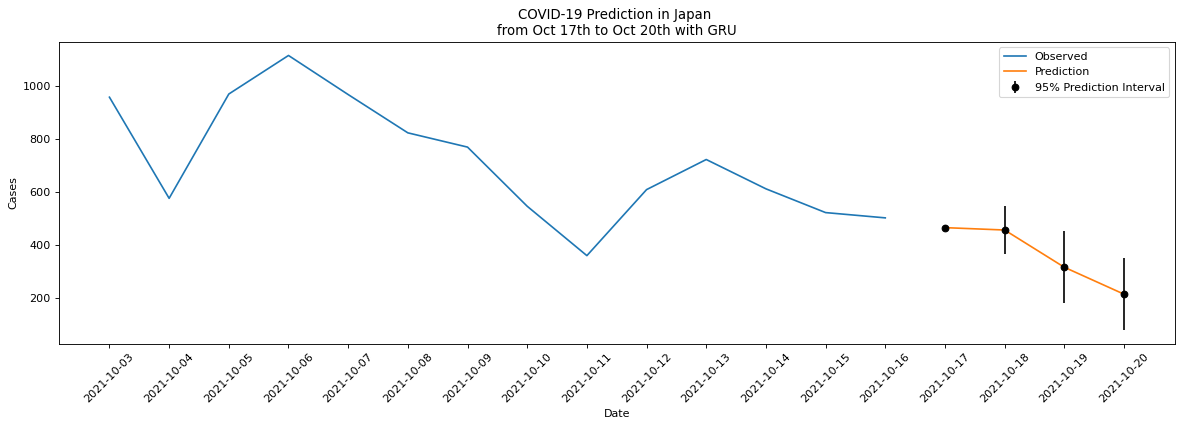

In [74]:
from matplotlib.pyplot import figure
figure(figsize=(18, 5), dpi=80)

plt.plot(time_range[:-4],df['Infected'][-14:], label='Observed')
plt.plot(time_range[-4:],y, label='Prediction')

plt.errorbar(time_range[-4], y[0], yerr=10.88631050218998 , color='black', fmt='o', label='95% Prediction Interval')
plt.errorbar(time_range[-3], y[1], yerr=92.64069418254607 , color='black', fmt='o')
plt.errorbar(time_range[-2], y[2], yerr=135.70149137432978, color='black', fmt='o')
plt.errorbar(time_range[-1], y[3], yerr=135.70149137432978, color='black', fmt='o')

plt.xlabel('Date')
plt.ylabel('Cases')
plt.xticks(time_range,rotation=45)
plt.title('COVID-19 Prediction in Japan \nfrom Oct 17th to Oct 20th with GRU')
plt.legend()
plt.show()

### Read data from source

In [9]:
df = pd.read_csv('https://toyokeizai.net/sp/visual/tko/covid19/csv/pcr_positive_daily.csv')
df = df.rename(columns={'日付': 'Date', 'PCR 検査陽性者数(単日)': 'Infected'}) #renaming from Japanese to English
df['Date'] = pd.to_datetime(df['Date'])
print(df.dtypes)
print(df.shape)
df.tail()

Date        datetime64[ns]
Infected           float64
dtype: object
(640, 2)


,Date,Infected
635,2021-10-12,609.0
636,2021-10-13,723.0
637,2021-10-14,612.0
638,2021-10-15,522.0
639,2021-10-16,502.0


### Load GRU

In [10]:
model_GRU = load_model('../GRU_infected_only_GRU_LSTM_Oct16.h5')
model_GRU

In [11]:
n_steps_in = 14
n_steps_out = 4

In [12]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))

In [13]:
x_input = df['Infected'][-n_steps_in:].values # last 14 day
x_input = sc.fit_transform(x_input.reshape(len(x_input), 1))
x_input = x_input.reshape((1, n_steps_in, 1))
print(x_input.shape)

(1, 14, 1)


In [14]:
y_pred_GRU = model_GRU.predict(x_input)
y_pred_GRU = sc.inverse_transform(y_pred_GRU) #revert scaling
print(y_pred_GRU)

[[443.1138  404.28793 357.68634 331.58417]]


In [15]:
x_input_raw = df['Infected'][-n_steps_in:].values
print(x_input_raw.reshape(n_steps_in))

[ 959.  576.  971. 1117.  969.  824.  770.  546.  359.  609.  723.  612.
  522.  502.]


### Range: 18 days

In [16]:
start_date = str(df['Date'].iloc[-14])[:10]

end_date = df['Date'].iloc[-15] + pd.Timedelta(18, unit='D')                  
end_date = str(end_date)[:10]

print(start_date,'---', end_date)

2021-10-03 --- 2021-10-20


In [17]:
time_range = pd.date_range(start=start_date, end=end_date)
print(time_range.shape)

(18,)


In [18]:
y_pred_GRU[0,:]

array([443.1138 , 404.28793, 357.68634, 331.58417], dtype=float32)

In [19]:
pred_list = list(zip(time_range[-4:].strftime('%Y-%m-%d'), y_pred_GRU[0,:]))
pred_list

[('2021-10-17', 443.1138),
 ('2021-10-18', 404.28793),
 ('2021-10-19', 357.68634),
 ('2021-10-20', 331.58417)]

In [20]:
pd.DataFrame (pred_list, columns = ['Date', 'Predict Infected'])

,Date,Predict Infected
0,2021-10-17,443.113800
1,2021-10-18,404.287933
2,2021-10-19,357.686340
3,2021-10-20,331.584167


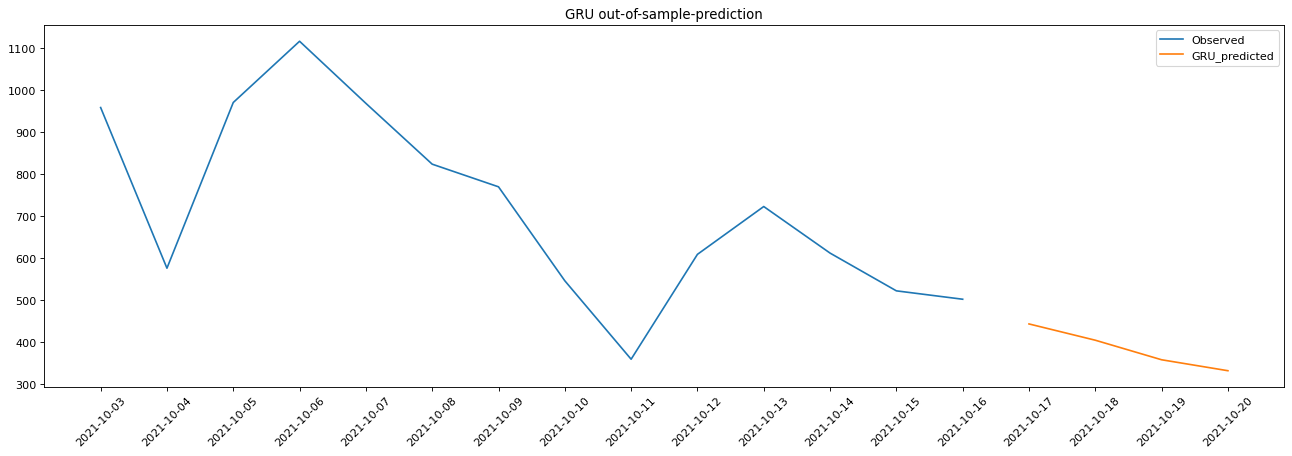

In [21]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.plot(time_range[:14],x_input_raw.reshape(n_steps_in), label='Observed')
plt.plot(time_range[14:], y_pred_GRU[0,:], label='GRU_predicted')
plt.title('GRU out-of-sample-prediction')
plt.xticks(time_range,rotation=45)
plt.legend()
plt.show()